In [1]:
import jax 
from utils.train import * 
from utils.utils import *
from utils.eval import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

2023-11-03 20:52:37.051903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dir_suffix = "2023-11-02-SA2I-2MLP"
save = False
config = {
	"model": A2ICoded,
    "N": 5,
    "feature_dim": 3, # this the number of classes under different features set, e.g. dim = 3 for 0, 1, 2
    "emb_dim":9,
    "qkv_features":9,
    "out_features":9,
    "num_episodes": 800000,
    "mlp_hidden": 128,
    "batch_size": 500,
    "learning_rate": 0.0001,
    "num_agents": 6,
    "init_rng": 123,
    "train_rng": 456,
    "eval_rng": 789,
    "num_heads": 1,
    "eval_runs":10,
    "batched_eval_runs":10,
    "eps_min":0.01,
    "eps_max":0.95,
    "K":5000,
    "eval_interval":800,
    "save_result": True,
    "xpeval_print": False,
    "training":True
    }

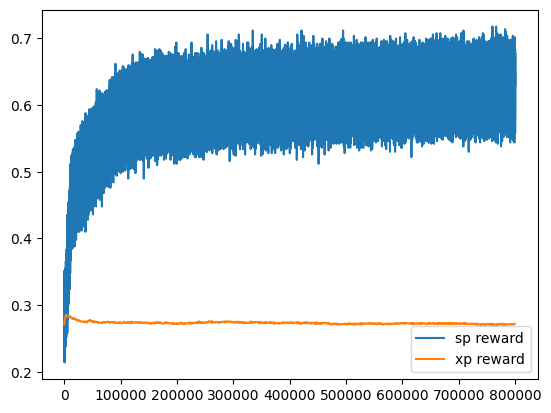

In [7]:
plot_sp_xp_result(dir_suffix, config, save)

100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


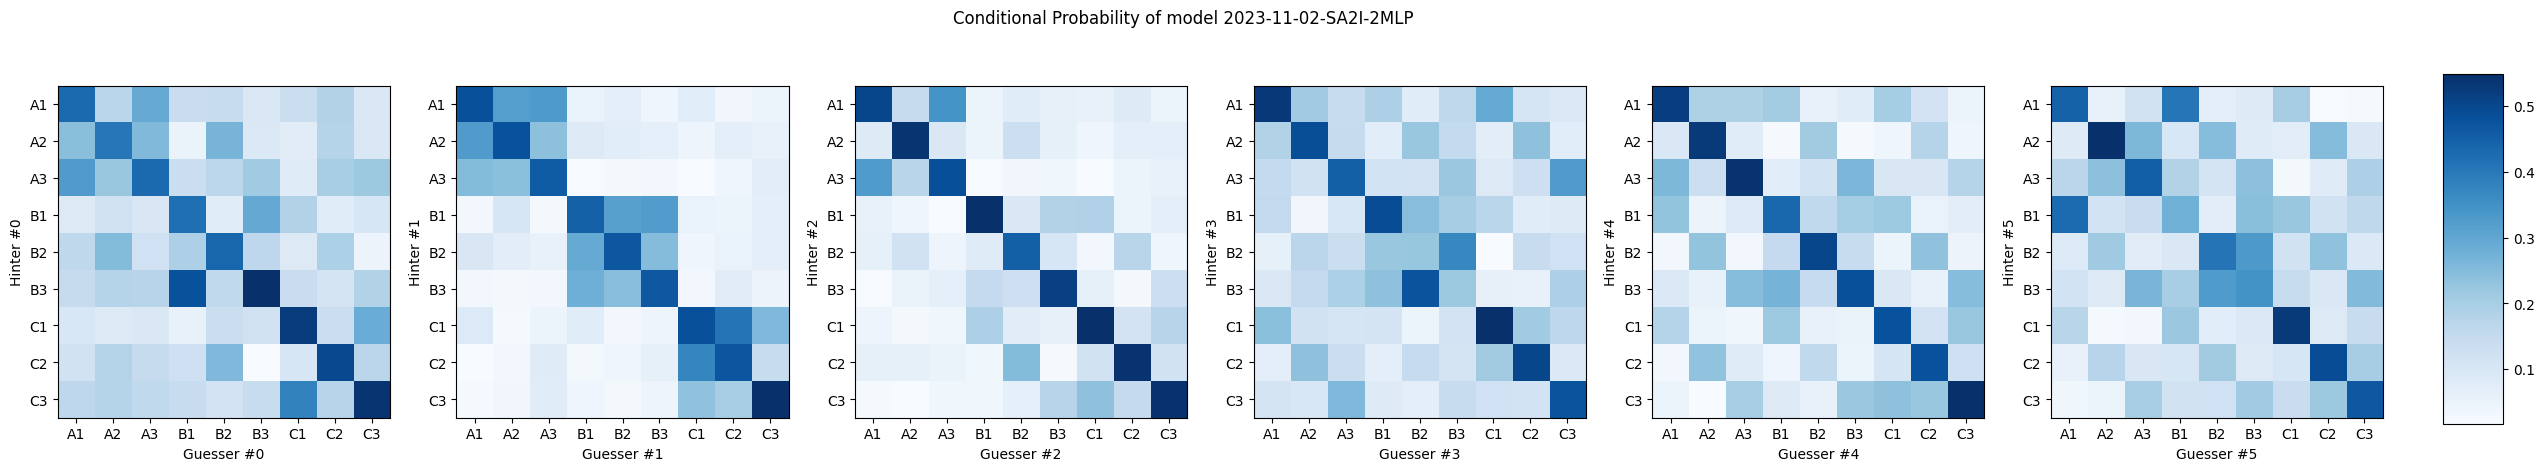

In [3]:
plot_cond_prob(dir_suffix, config, save=False)

In [4]:
plot_xp(dir_suffix, config)

 70%|███████   | 7/10 [00:01<00:00,  4.47it/s]

In [ ]:
from models.SA2I import * 
model_test()

(256, 5)


In [ ]:
a = jnp.arange(16).reshape(2, 2, 2, 2)
dim = a.ndim
axes = jnp.arange(dim)
a = jnp.repeat(a, 4, axis=0)
a = jnp.transpose(a, axes=(1, 0,)+axes[1:])
print(a)

AttributeError: 'tuple' object has no attribute 'shape'